In [19]:
import numpy as np
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

import synth_gen

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys
sys.path.append("../twintest")

import causality as intest
import viz

In [58]:
target = 1 # By defaul X->Y
nb_samples = 100

Nx = {
    'name': 'exp',
    'var': 5
}

Ny = {
    'name': 'normal',
    'var': 1#4.87 
    # 4.86 - 87 - 88
}


f = lambda x:  .5*( 7*np.tanh(x) + 4*np.sin(x)+ x + x ** 2 + .1 *x**3)

In [59]:
binary_am = synth_gen.BinaryAM(Nx, Ny, f, nb_samples)
x = binary_am.x.reshape(-1, 1)
y = binary_am.y

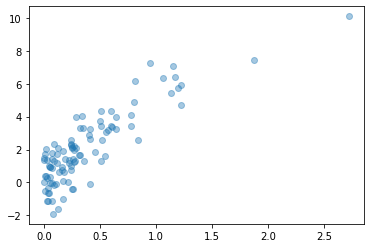

In [60]:
viz.pretty_scatter(x, y)

In [61]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

    Default model

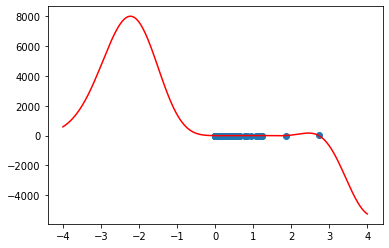

In [62]:
clf = GaussianProcessRegressor(random_state=42)
clf.fit(x, y)
x_linspace = np.atleast_2d(np.linspace(-4, 4, 1000)).T
y_pred = clf.predict(x_linspace)

plt.plot(x_linspace, y_pred, c='r')
plt.scatter(x, y)

In [63]:
# Define kernel parameters. 
l = .01
sigma_f = 2

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-2, 1e2)) \
            + WhiteKernel(noise_level=100, noise_level_bounds=(1e-10, 1e+1))

In [64]:
clf = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0)
clf.fit(x, y)

GaussianProcessRegressor(alpha=0, copy_X_train=True,
                         kernel=1.41**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=100),
                         n_restarts_optimizer=10, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

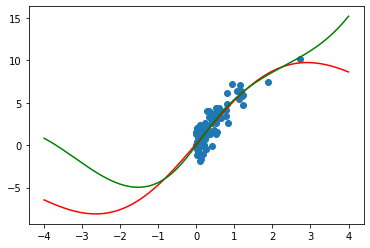

In [65]:
x_linspace = np.atleast_2d(np.linspace(-4, 4, 1000)).T
y_pred = clf.predict(x_linspace)

plt.plot(x_linspace, y_pred, c='r')
plt.plot(x_linspace, f(x_linspace), c='g')
plt.scatter(x, y)

In [11]:
# Set dimension. 
d = 1
# Number of training points.
n = 1000
# Length of the training set. 
L = 2
# Generate training features.
x = np.linspace(start=0, stop=L, num=n)
X = x.reshape(n, d)
# Error standar deviation. 
sigma_n = 0.4
# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)

# Generate non-linear function.
def f(x):
    f = np.sin((4*np.pi)*x) + np.sin((7*np.pi)*x) + np.sin((3*np.pi)*x) 
    return(f)

f_x = f(x)

# Observed target variable. 
y = f_x + epsilon

In [12]:
n_star = n + 300
x_star = np.linspace(start=0, stop=(L + 0.5), num=n_star)

X_star = x_star.reshape(n_star, d)

In [13]:
# Define kernel parameters. 
l = 0.1
sigma_f = 2

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-2, 1e2))
# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10, )

In [14]:
# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X, y)
# Make the prediction on test set.
y_pred = gp.predict(X_star)

In [15]:
# Generate samples from posterior distribution. 
y_hat_samples = gp.sample_y(X_star, n_samples=n_star)
# Compute the mean of the sample. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=1).squeeze()
# Compute the standard deviation of the sample. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

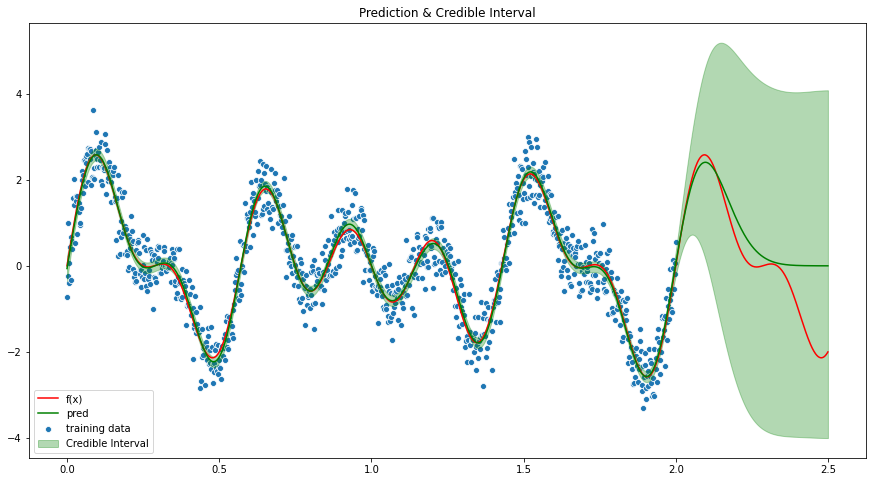

In [16]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 8))
# Plot training data.
sns.scatterplot(x=x, y=y, label='training data', ax=ax);
# Plot "true" linear fit.
sns.lineplot(
    x=x_star, 
    y=f(x_star), 
    color='red', 
    label='f(x)', 
    ax=ax
)
# Plot corridor. 
ax.fill_between(
    x=x_star, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='green',
    alpha=0.3, 
    label='Credible Interval'
)
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='pred')
ax.set(title='Prediction & Credible Interval')
ax.legend(loc='lower left');